# **Regressor Algorithms**

The experiments conducted using different feature selections methods such as PCA, Correlation, RandomForest based feature selections and the last was without feature selection. Experiment algorithms are as follows:

- SVM Regressor
- Gradient Boosting Regressor
- Cat Boost Regressor
- XGBoost Regressor
- K-NN Regressor

In [ ]:
!pip install catboost

     |████████████████████████████████| 65.9MB 57kB/s 


In [1]:
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, MinMaxScaler, Normalizer, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_auc_score,roc_curve, classification_report
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

import timeit
from warnings import filterwarnings
filterwarnings('ignore')

/home/asus/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)
/home/asus/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def layer1(data, remove_col, threshold):
    corr_col=set()
    data2 = data.drop(remove_col, axis=1)
    corrmat=data2.corr()
    for i in range(len(corrmat.columns)):
        for j in range(i):
            if abs(corrmat.iloc[i,j] > threshold):
                colname=corrmat.columns[i]
                corr_col.add(colname)
    corr_col=list(corr_col)
    layer1_df = data.drop(corr_col, axis=1)
    #layer1_df["labels"] = data_norm["labels"]
    return layer1_df


def correlation_df(data, remove_columns=None):
    if(remove_columns is None):
        corr = data.corr()
        corr = corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))
        corr = corr.stack().reset_index()
        new_df = corr[corr["level_0"] != corr["level_1"]]
        new_df.columns = ['feature1','feature2','Corr']
        new_df["Corr"] = abs(new_df["Corr"])
    else:
        data2 = data.drop(remove_columns, axis=1)
        corr = data2.corr()
        corr = corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))
        corr = corr.stack().reset_index()
        new_df = corr[corr["level_0"] != corr["level_1"]]
        new_df.columns = ['feature1','feature2','Corr']
        new_df["Corr"] = abs(new_df["Corr"])
    return new_df

def numeric_categoric_variable(data):
    name_of_col = list(data.columns)
    num_var_list = []
    str_var_list = []
    drop_col=[]

    str_var_list = name_of_col.copy()
    for var in name_of_col:
        # check if column belongs to numeric type
        if (data[var].dtypes not in (np.object, np.str)):
            str_var_list.remove(var)
            num_var_list.append(var)
        # drop the omit column from list
    for var in drop_col:
        if var in str_var_list:
            str_var_list.remove(var)
        if var in num_var_list:
            num_var_list.remove(var)
    print("Numeric Column  :\n", num_var_list,
          "\n\nCategoric Column :\n", str_var_list)
    return num_var_list, str_var_list

def sortDifferentCategory(data):
    def takeSecond(elem):
        return elem[1]

    listem = []
    for i in data.select_dtypes(include=["object", "int64", "float64"]).columns:
        listem.append([i, data[i].value_counts().count()])

    return sorted(listem, key=takeSecond ,reverse=False)


def layer2(new_df, target, num_feats):
    x = new_df.drop(target, axis=1)
    y = new_df[target]
    cor_list = []
    feature_name = list(x.columns)
    for i in list(x.columns):
        cor = np.corrcoef(x[i],y)[0,1]
        cor_list.append(cor)

    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    cor_feature = x.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    return cor_feature

def featureselection_pca(data_minmax, target, threshold):
    x = data_minmax.drop([target], axis=1)
    y = data_minmax[target]
    pca = PCA()    
    X_pca = pca.fit_transform(x)
    arr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals = 4)*100)
    num_var = sum((arr < threshold*100)) + 1 
    print('pca sonrası değişken sayısı: ',num_var)
    X_pcad = pd.DataFrame(X_pca[:,0:num_var], index = x.index)
    X_pcad[target] = y
    return X_pcad

def featureselection_corrcorr(data, target, threshold, num_feat):
    layer1_df = layer1(data, target, threshold)
    last_features = layer2(layer1_df, target, num_feat)
    reduced_df = data[last_features]
    reduced_df[target] = data[target]
    return reduced_df

In [3]:
def featureselection_randomforest(xtrain,ytrain, target, params, top_feat, cv=10, n_jobs=-1, verbose=2):
    model = RandomForestRegressor()
    gridsearch_cv = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_cv_model = gridsearch_cv.fit(xtrain, ytrain)
    # best parameters
    model.max_depth = grid_cv_model.best_params_["max_depth"]
    model.max_features = grid_cv_model.best_params_["max_features"] 
    model.n_estimators = grid_cv_model.best_params_["n_estimators"]
    model.min_samples_split= grid_cv_model.best_params_["min_samples_split"]
    # tuned model
    model_tuned = model.fit(xtrain, ytrain)
    #y_pred = model_tuned.predict(xtest)
    
    importance = pd.DataFrame({"importance": model.feature_importances_*100}, index = xtrain.columns)
    rf_columns = importance.sort_values(by="importance", axis=0, ascending=False).head(top_feat).index
    new_df = xtrain[rf_columns]
    new_df[target] = ytrain
    return new_df

def describe(data):
    desc_df = data.describe().T
    null_count = data.isnull().sum()
    null_percent = (data.isnull().sum() / data.count())*100
    variance = data.var()

    desc_df["variance"] =  round(variance,3)
    desc_df["null_values"] = round(null_count,3)
    desc_df["null__rate"] = round(null_percent,3)
    return desc_df.T

def normalization_minmax(dataframe, target):
    x = dataframe
    y = dataframe[target]
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(x)
    array = scaler.transform(x)
    data_minmax = pd.DataFrame(array, columns=dataframe.columns)
    data_minmax[target] = y
    return data_minmax

def nulldata_check(data, ascending=False):
    count = data.isnull().sum().sort_values(ascending=ascending).to_frame()
    percent = (data.isnull().sum().sort_values(ascending=ascending)/data.iloc[:,-1].count()).to_frame().round(decimals=4)
    df = pd.concat([count, percent], axis=1)
    df.columns = ["count","percentage"]
    return df

In [4]:
def evaluation_metrics(ytest, y_pred):
    print("MSE : ",mean_squared_error(ytest, y_pred))
    print("RMSE: ",np.sqrt(mean_squared_error(ytest, y_pred)))
    print("MAE : ",mean_absolute_error(ytest, y_pred))
    
def dummy_df(df, todummy_list):
    for x in todummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x, 1)
        df = pd.concat([df, dummies], axis=1)
    return df

def train_test_splitting(data, target, test_size=0.25, random_state=0, shuffle=False):
    x = data.drop([target], axis=1)
    y = data[target]
    xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=test_size, random_state=random_state, shuffle=shuffle)
    print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)
    return xtrain, xtest, ytrain, ytest

### **Data Importing**

In [8]:
data = pd.read_excel("HW_Data_Set.xlsx")
data.head()

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_416,ind_418,ind_420,ind_422,ind_424,ind_426,ind_428,20_target,50_target,90_target
0,19,17,100.0,85.714286,14.285714,72.363515,60.808814,23.80,17.62,11.73,...,-49.6,-54,-152,-353,1.0,0.498547,0.701906,15.135802,35.625252,36.997753
1,24,19,100.0,78.571429,21.428571,74.275883,64.366798,11.45,18.16,12.22,...,-55.6,-60,-158,-359,1.0,0.537088,0.690833,15.143348,35.643013,37.016198
2,30,24,100.0,71.428571,28.571429,75.140402,65.915803,8.75,17.86,12.28,...,-58.4,-60,-160,-362,1.0,0.615169,0.693040,15.146870,35.651301,-37.024805
3,37,30,100.0,64.285714,35.714286,76.677846,68.584234,7.80,14.76,12.61,...,-61.8,-65,-166,-367,1.0,0.661517,0.673418,15.153283,0.000000,-37.040483
4,41,37,100.0,57.142857,42.857143,81.603007,76.455495,14.90,11.92,14.25,...,-79.8,-86,-186,-388,1.0,0.747204,0.700522,-15.179065,-35.727079,-37.103503


## 1. **Data Statistics**

In [9]:
data.shape

(6167, 136)

### **1.1. Describe Dataset**

In [10]:
describe(data)

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_412,ind_414,ind_416,ind_418,ind_424,ind_426,ind_428,20_target,50_target,90_target
count,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,...,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000
mean,-0.803146,-0.803470,48.388890,48.289282,0.099609,49.488867,-18.497518,11.771485,11.773550,11.773392,...,0.000224,28.529204,-8.554792,-28.166694,0.490297,0.498188,0.490174,-0.057102,-2.906358,-3.315072
std,23.624403,23.624144,36.388526,36.478009,60.414625,12.198722,68.281120,6.803997,5.786089,4.970499,...,0.005660,26.316896,16.100087,23.271524,0.425376,0.228547,0.150483,14.834497,34.559778,36.841541
min,-131.000000,-131.000000,0.000000,0.000000,-100.000000,12.134540,-625.093855,1.050000,1.660000,2.580000,...,-0.023790,0.000000,-103.800000,-188.000000,0.000000,0.000000,0.083530,-15.780588,-37.142889,-38.573858
25%,-14.000000,-14.000000,14.285714,14.285714,-50.000000,40.868503,-45.687212,6.850000,7.260000,7.635000,...,-0.003230,10.700000,-11.700000,-39.000000,0.000000,0.323783,0.379894,-15.350354,-36.208094,-37.695273
50%,0.000000,0.000000,50.000000,50.000000,0.000000,49.549766,-2.817298,10.550000,11.040000,11.270000,...,-0.000053,21.300000,0.000000,-22.000000,0.473684,0.495192,0.487078,0.000000,-34.267756,-35.788391
75%,13.000000,13.000000,85.714286,85.714286,57.142857,58.504375,28.072613,14.950000,15.040000,14.960000,...,0.003414,38.400000,0.000000,-11.000000,1.000000,0.675730,0.601508,15.385945,35.879524,37.521892
max,76.000000,76.000000,100.000000,100.000000,100.000000,84.821848,81.105847,82.900000,54.240000,37.050000,...,0.023340,281.800000,0.000000,0.000000,1.000000,1.000000,0.868534,15.768767,37.038694,38.465649
variance,558.112000,558.100000,1324.125000,1330.645000,3649.927000,148.809000,4662.311000,46.294000,33.479000,24.706000,...,0.000000,692.579000,259.213000,541.564000,0.181000,0.052000,0.023000,220.062000,1194.378000,1357.299000
null_values,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### **1.2. Categoric and Numeric variables Analysis**

In [11]:
num, cat = numeric_categoric_variable(data)

Numeric Column  :
 ['ind_5', 'ind_6', 'ind_8', 'ind_9', 'ind_10', 'ind_12', 'ind_13', 'ind_14', 'ind_15', 'ind_16', 'ind_17', 'ind_18', 'ind_19', 'ind_20', 'ind_21', 'ind_22', 'ind_23', 'ind_25', 'ind_26', 'ind_27', 'ind_28', 'ind_29', 'ind_30', 'ind_31', 'ind_32', 'ind_33', 'ind_34', 'ind_35', 'ind_36', 'ind_37', 'ind_39', 'ind_40', 'ind_41', 'ind_42', 'ind_43', 'ind_44', 'ind_45', 'ind_46', 'ind_47', 'ind_48', 'ind_49', 'ind_50', 'ind_51', 'ind_52', 'ind_53', 'ind_56', 'ind_58', 'ind_61', 'ind_62', 'ind_65', 'ind_67', 'ind_70', 'ind_71', 'ind_74', 'ind_77', 'ind_82', 'ind_83', 'ind_88', 'ind_92', 'ind_102', 'ind_116', 'ind_118', 'ind_122', 'ind_124', 'ind_128', 'ind_130', 'ind_132', 'ind_134', 'ind_136', 'ind_139', 'ind_142', 'ind_145', 'ind_147', 'ind_150', 'ind_153', 'ind_156', 'ind_164', 'ind_168', 'ind_172', 'ind_176', 'ind_179', 'ind_181', 'ind_188', 'ind_194', 'ind_212', 'ind_217', 'ind_225', 'ind_228', 'ind_234', 'ind_237', 'ind_239', 'ind_241', 'ind_243', 'ind_309', 'ind_310'

In [12]:
sortDifferentCategory(data)

[['ind_109', 2],
 ['ind_40', 6],
 ['ind_82', 6],
 ['ind_217', 6],
 ['ind_28', 7],
 ['ind_349', 7],
 ['ind_8', 15],
 ['ind_9', 15],
 ['ind_351', 17],
 ['ind_352', 17],
 ['ind_70', 18],
 ['ind_67', 22],
 ['ind_344', 22],
 ['ind_83', 25],
 ['ind_10', 29],
 ['ind_77', 37],
 ['ind_61', 38],
 ['ind_74', 42],
 ['ind_71', 46],
 ['ind_58', 50],
 ['ind_122', 52],
 ['ind_65', 55],
 ['ind_62', 64],
 ['ind_347', 69],
 ['ind_42', 71],
 ['ind_334', 71],
 ['ind_19', 83],
 ['ind_21', 84],
 ['ind_52', 90],
 ['ind_136', 91],
 ['ind_134', 93],
 ['ind_43', 94],
 ['ind_56', 102],
 ['ind_407', 103],
 ['ind_345', 108],
 ['ind_44', 109],
 ['ind_45', 126],
 ['ind_124', 128],
 ['ind_53', 131],
 ['ind_116', 131],
 ['ind_46', 135],
 ['ind_418', 139],
 ['ind_20', 141],
 ['ind_410', 143],
 ['ind_234', 157],
 ['ind_47', 159],
 ['ind_5', 162],
 ['ind_6', 162],
 ['ind_48', 175],
 ['ind_23', 177],
 ['ind_49', 189],
 ['ind_22', 192],
 ['ind_406', 200],
 ['ind_128', 201],
 ['ind_324', 241],
 ['ind_309', 249],
 ['ind_50', 

In [13]:
data.groupby("ind_40").count()

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_416,ind_418,ind_420,ind_422,ind_424,ind_426,ind_428,20_target,50_target,90_target
ind_40,,,,,,,,,,,,,,,,,,,,,
1,51,51,51,51,51,51,51,51,51,51,...,51,51,51,51,51,51,51,51,51,51
2,325,325,325,325,325,325,325,325,325,325,...,325,325,325,325,325,325,325,325,325,325
3,2799,2799,2799,2799,2799,2799,2799,2799,2799,2799,...,2799,2799,2799,2799,2799,2799,2799,2799,2799,2799
4,2594,2594,2594,2594,2594,2594,2594,2594,2594,2594,...,2594,2594,2594,2594,2594,2594,2594,2594,2594,2594
5,319,319,319,319,319,319,319,319,319,319,...,319,319,319,319,319,319,319,319,319,319
6,79,79,79,79,79,79,79,79,79,79,...,79,79,79,79,79,79,79,79,79,79


In [14]:
data.groupby("ind_420").count().tail(5)

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_414,ind_416,ind_418,ind_422,ind_424,ind_426,ind_428,20_target,50_target,90_target
ind_420,,,,,,,,,,,,,,,,,,,,,
288,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
290,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
291,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
297,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
?,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,...,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041


### **1.3. NULL Value Checking**

In [15]:
nulldata_check(data).sort_values(by="count",ascending=False).head(7)

,count,percentage
90_target,0,0.0
ind_416,0,0.0
ind_404,0,0.0
ind_406,0,0.0
ind_407,0,0.0
ind_410,0,0.0
ind_412,0,0.0


# **2. Data Preprocessing**

### **2.1. Noise data cleaning**

In [16]:
#data["ind_420"] = data["ind_420"].replace("?", np.nan)
#data["ind_422"] = data["ind_422"].replace("?", np.nan)
data = data.drop(["ind_420", "ind_422"],axis=1)

### **2.2. Dummy Transformation**

In [17]:
data_dummy = dummy_df(data, ["ind_109"])
data_dummy2 = dummy_df(data, ["ind_109","ind_40"])

num, cat = numeric_categoric_variable(data_dummy)
data_dummy.head()

Numeric Column  :
 ['ind_5', 'ind_6', 'ind_8', 'ind_9', 'ind_10', 'ind_12', 'ind_13', 'ind_14', 'ind_15', 'ind_16', 'ind_17', 'ind_18', 'ind_19', 'ind_20', 'ind_21', 'ind_22', 'ind_23', 'ind_25', 'ind_26', 'ind_27', 'ind_28', 'ind_29', 'ind_30', 'ind_31', 'ind_32', 'ind_33', 'ind_34', 'ind_35', 'ind_36', 'ind_37', 'ind_39', 'ind_40', 'ind_41', 'ind_42', 'ind_43', 'ind_44', 'ind_45', 'ind_46', 'ind_47', 'ind_48', 'ind_49', 'ind_50', 'ind_51', 'ind_52', 'ind_53', 'ind_56', 'ind_58', 'ind_61', 'ind_62', 'ind_65', 'ind_67', 'ind_70', 'ind_71', 'ind_74', 'ind_77', 'ind_82', 'ind_83', 'ind_88', 'ind_92', 'ind_102', 'ind_116', 'ind_118', 'ind_122', 'ind_124', 'ind_128', 'ind_130', 'ind_132', 'ind_134', 'ind_136', 'ind_139', 'ind_142', 'ind_145', 'ind_147', 'ind_150', 'ind_153', 'ind_156', 'ind_164', 'ind_168', 'ind_172', 'ind_176', 'ind_179', 'ind_181', 'ind_188', 'ind_194', 'ind_212', 'ind_217', 'ind_225', 'ind_228', 'ind_234', 'ind_237', 'ind_239', 'ind_241', 'ind_243', 'ind_309', 'ind_310'

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_416,ind_418,ind_424,ind_426,ind_428,20_target,50_target,90_target,ind_109_GREEN,ind_109_RED
0,19,17,100.0,85.714286,14.285714,72.363515,60.808814,23.80,17.62,11.73,...,-49.6,-54,1.0,0.498547,0.701906,15.135802,35.625252,36.997753,1,0
1,24,19,100.0,78.571429,21.428571,74.275883,64.366798,11.45,18.16,12.22,...,-55.6,-60,1.0,0.537088,0.690833,15.143348,35.643013,37.016198,1,0
2,30,24,100.0,71.428571,28.571429,75.140402,65.915803,8.75,17.86,12.28,...,-58.4,-60,1.0,0.615169,0.693040,15.146870,35.651301,-37.024805,1,0
3,37,30,100.0,64.285714,35.714286,76.677846,68.584234,7.80,14.76,12.61,...,-61.8,-65,1.0,0.661517,0.673418,15.153283,0.000000,-37.040483,1,0
4,41,37,100.0,57.142857,42.857143,81.603007,76.455495,14.90,11.92,14.25,...,-79.8,-86,1.0,0.747204,0.700522,-15.179065,-35.727079,-37.103503,1,0


### **2.3. Normalization (Min-Max)**

In [18]:
data_norm_20target = data_dummy.drop(["50_target", "90_target"],axis=1)
data_minmax_20target = normalization_minmax(data_norm_20target, "20_target")

data_norm_50target = data_dummy.drop(["20_target", "90_target"],axis=1)
data_minmax_50target = normalization_minmax(data_norm_50target, "50_target")

data_norm_90target = data_dummy.drop(["20_target", "50_target"],axis=1)
data_minmax_90target = normalization_minmax(data_norm_90target, "90_target")


data_minmax_50target.head(3)

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_412,ind_414,ind_416,ind_418,ind_424,ind_426,ind_428,50_target,ind_109_GREEN,ind_109_RED
0,0.724638,0.714976,1.0,0.857143,0.571429,0.828604,0.971259,0.277947,0.303537,0.265448,...,0.555085,0.007097,0.522158,0.712766,1.0,0.498547,0.787736,35.625252,1.0,0.0
1,0.748792,0.724638,1.0,0.785714,0.607143,0.854913,0.976297,0.127062,0.313808,0.279663,...,0.570000,0.002839,0.464355,0.680851,1.0,0.537088,0.773630,35.643013,1.0,0.0
2,0.777778,0.748792,1.0,0.714286,0.642857,0.866807,0.978490,0.094075,0.308102,0.281404,...,0.580332,0.009581,0.437380,0.680851,1.0,0.615169,0.776441,35.651301,1.0,0.0


# **3. Feature Selection**

### **3.1. Principal Component Analysis**

In [19]:
data_pca_20target = featureselection_pca(data_minmax_20target, "20_target", 0.9)
data_pca_50target = featureselection_pca(data_minmax_50target, "50_target", 0.9)
data_pca_90target = featureselection_pca(data_minmax_90target, "90_target", 0.9)
data_pca_50target.head()

pca sonrası değişken sayısı:  19
pca sonrası değişken sayısı:  19
pca sonrası değişken sayısı:  19


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,50_target
0,-1.918783,0.126473,-0.295048,0.400703,-0.076268,0.371339,0.347380,-0.614152,0.282158,0.352373,-0.385728,0.818448,0.255718,-0.452354,-0.168721,0.117936,-0.221845,0.385469,-0.012100,35.625252
1,-2.043020,0.117548,-0.204928,0.347276,-0.056899,0.328800,0.365171,-0.610495,0.253421,0.346037,-0.296312,0.821816,0.245115,-0.469800,-0.207842,0.104446,-0.231889,0.383681,-0.007942,35.643013
2,-2.088737,0.072149,-0.135119,0.317724,-0.062843,0.280218,0.375154,-0.605005,0.232259,0.319001,-0.261715,0.788576,0.268427,-0.474156,-0.203423,0.089478,-0.246062,0.361119,-0.002372,35.651301
3,-2.203106,0.090405,-0.066407,0.261085,-0.005468,0.251994,0.388037,-0.587139,0.199041,0.326763,-0.170757,0.828007,0.252351,-0.480077,-0.183597,0.063912,-0.240448,0.327890,0.011579,0.000000
4,-2.528751,0.126773,0.046819,0.234280,0.029756,0.354077,0.427985,-0.621044,0.236388,0.310995,-0.077167,0.849048,0.119429,-0.508945,-0.242452,0.143253,-0.363971,0.486983,-0.044026,-35.727079


### **3.2. Correlation based Feature Selection**

In [20]:
data_corr_20target = featureselection_corrcorr(data_minmax_20target, "20_target", 0.6, 8)
data_corr_50target = featureselection_corrcorr(data_minmax_50target, "50_target", 0.6, 8)
data_corr_90target = featureselection_corrcorr(data_minmax_90target, "90_target", 0.6, 8)
data_corr_90target.head()

,ind_316,ind_310,ind_14,ind_26,ind_330,ind_324,ind_332,ind_18,90_target
0,0.979995,0.207870,0.277947,0.786663,0.944473,0.960129,0.210376,0.179402,36.997753
1,0.979540,0.208265,0.127062,0.751886,0.944500,0.960129,0.208693,0.184535,37.016198
2,0.979346,0.208449,0.094075,0.718925,0.944513,0.960129,0.207037,0.188641,-37.024805
3,0.978964,0.208784,0.082468,0.684934,0.944537,0.960129,0.205407,0.193317,-37.040483
4,0.977335,0.210127,0.169212,0.632729,0.944631,0.960129,0.203802,0.215100,-37.103503


### **3.3. RandomForestRegressor based Feature Selection**

In [22]:
def x_and_y(data_minmax, target):
    x= data_minmax.drop(target, axis=1)
    y = data_minmax[target]
    return x,y

In [23]:
rf_params = {"max_depth": [2,5,7,8],
             "max_features": [3,4,5],
             "n_estimators": [50,100],
             "min_samples_split": [5,10]}

x,y = x_and_y(data_minmax_20target, "20_target")
data_rf_20target = featureselection_randomforest(x,y, "20_target", rf_params, 10) 

x,y = x_and_y(data_minmax_50target, "50_target")
data_rf_50target = featureselection_randomforest(x,y, "50_target", rf_params, 10) 

x,y = x_and_y(data_minmax_90target, "90_target")
data_rf_90target = featureselection_randomforest(x,y, "90_target", rf_params, 10) 


data_rf_50target.head()

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  1.4min finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   29.2s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   29.8s finished


,ind_309,ind_243,ind_17,ind_313,ind_36,ind_228,ind_225,ind_74,ind_77,ind_330,50_target
0,0.981941,0.957122,0.235051,0.954773,0.741258,0.956983,0.241577,0.666667,0.690476,0.944473,35.625252
1,0.981941,0.956949,0.215299,0.954784,0.746867,0.956855,0.241457,0.666667,0.690476,0.944500,35.643013
2,0.981941,0.956776,0.205782,0.954795,0.750682,0.956728,0.241401,0.666667,0.690476,0.944513,35.651301
3,0.981941,0.956602,0.191058,0.954805,0.748941,0.956600,0.241299,0.666667,0.690476,0.944537,0.000000
4,0.981941,0.956429,0.217454,0.954816,0.775328,0.956473,0.240889,0.666667,0.690476,0.944631,-35.727079


# **4. Visualization**

### **4.1. Correlation HeatMap**

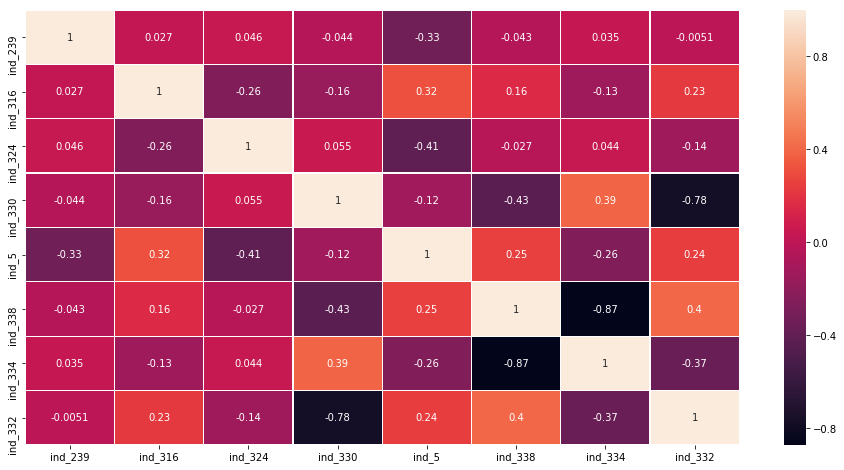

In [24]:
def heatmap(data, figsize=(16,8)):
    fig, ax = plt.subplots(figsize=figsize)   
    sns.heatmap(data.corr(), annot=True, linewidths=.3, ax=ax)
    plt.show()
    
heatmap(data_corr_20target.drop(["20_target"], axis=1))

In [25]:
print("Most Correlated\n",correlation_df(data_corr_50target.drop(["50_target"],axis=1)).sort_values(by="Corr", ascending=False).head(5),"\n")
print("Less Correlated\n",correlation_df(data_corr_50target.drop(["50_target"],axis=1)).sort_values(by="Corr", ascending=True).head(5),"\n")

Most Correlated
    feature1 feature2      Corr
23  ind_330  ind_332  0.775937
11   ind_14   ind_26  0.485883
6     ind_5  ind_324  0.409430
29   ind_26   ind_18  0.361721
20  ind_310   ind_18  0.296947 

Less Correlated
    feature1 feature2      Corr
27   ind_26  ind_332  0.001387
4     ind_5   ind_26  0.012802
1     ind_5   ind_14  0.014502
2     ind_5  ind_310  0.020973
13   ind_14  ind_324  0.027027 



### **4.2. Scatter Plot**

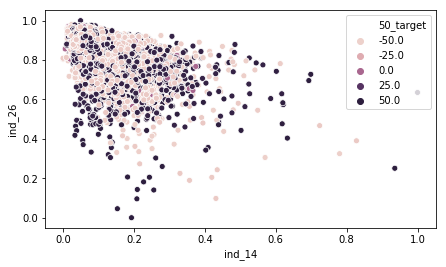

In [26]:
def scatterplot(x,y, hue, data, figsize=(7,4)):
    fig, ax = plt.subplots(figsize=figsize)        
    sns.scatterplot(x=x, y=y, hue=hue, data=data, ax=ax)
    plt.show()

scatterplot("ind_14", "ind_26", "50_target", data_corr_50target)

### **4.3. Box Plot (Five Numbers Summary)**

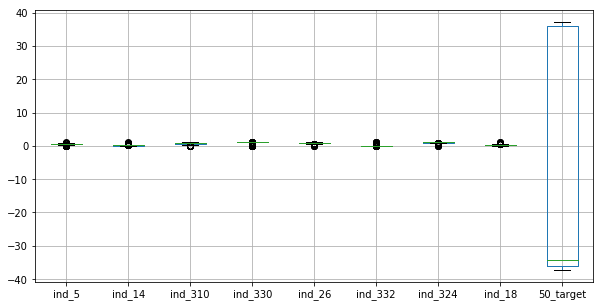

In [27]:
def boxplot(boxplot_df, figsize=(10,5)):
    plt.figure(figsize=figsize)
    boxplot_df.boxplot()
    plt.show()

boxplot(data_corr_50target)

### **4.4. Histogram (Distribution)**

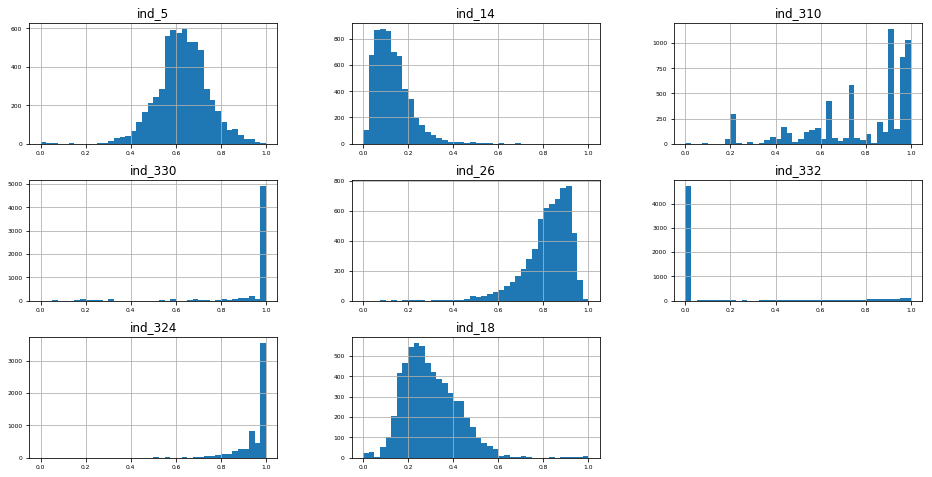

In [28]:
def histogram(datas, bins=40, xlabelsize=6, ylabelsize=6, figsize=(10,5)):
    datas.hist(figsize=figsize, bins=bins, xlabelsize=xlabelsize, ylabelsize=ylabelsize)
    plt.show()
    
histogram(data_corr_50target.drop(["50_target"],axis=1), figsize=(16,8))

# **5. Modelling (Algorithms)**
- SVM Regressor
- Gradient Boosting Regressor
- Cat Boost Regressor
- XGBoost Regressor
- KNN Regressor

## **5.1. SVM Regressor**

### **5.1.1. PCA based FS**

In [58]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_pca_20target, "20_target")
svr = SVR()
svr_model = svr.fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_pca_50target, "50_target")
svr_model = SVR().fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_pca_90target, "90_target")
svr_model = SVR().fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

(4625, 19) (1542, 19) (4625,) (1542,)
MSE :  239.36686220408228
RMSE:  15.471485455640073
MAE :  14.283753909306627


(4625, 19) (1542, 19) (4625,) (1542,)
MSE :  1593.0279533560158
RMSE:  39.91275426923098
MAE :  33.47009109266908


(4625, 19) (1542, 19) (4625,) (1542,)
MSE :  2062.5670585747694
RMSE:  45.41549359607104
MAE :  33.16242289141083




### **5.1.2. Correlation based FS**

In [30]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr_20target, "20_target")
svr_model = SVR().fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr_50target, "50_target")
svr_model = SVR().fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr_90target, "90_target")
svr_model = SVR().fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

(4625, 8) (1542, 8) (4625,) (1542,)
MSE :  214.0049425828749
RMSE:  14.628907771357193
MAE :  14.259698708312802


(4625, 8) (1542, 8) (4625,) (1542,)
MSE :  1958.2577941961015
RMSE:  44.252206659059404
MAE :  31.46691984009197


(4625, 8) (1542, 8) (4625,) (1542,)
MSE :  2247.2124074788635
RMSE:  47.404771990579846
MAE :  32.48698480900217




#### **5.1.3. RandomForest based FS**

In [31]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_rf_20target, "20_target")
svr_model = SVR().fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_rf_50target, "50_target")
svr_model = SVR().fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_rf_90target, "90_target")
svr_model = SVR().fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

(4625, 10) (1542, 10) (4625,) (1542,)
MSE :  213.39415203576232
RMSE:  14.608016704390858
MAE :  14.154191485393268


(4625, 10) (1542, 10) (4625,) (1542,)
MSE :  1694.4276014128977
RMSE:  41.163425530595696
MAE :  32.71651872876039


(4625, 10) (1542, 10) (4625,) (1542,)
MSE :  2255.3505890920233
RMSE:  47.490531573062256
MAE :  32.82889392706668




In [32]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_minmax_20target, "20_target")
svr_model = SVR().fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_minmax_50target, "50_target")
svr_model = SVR().fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_minmax_90target, "90_target")
svr_model = SVR().fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

(4625, 132) (1542, 132) (4625,) (1542,)
MSE :  209.09076023502757
RMSE:  14.45997096245451
MAE :  14.18101621810999


(4625, 132) (1542, 132) (4625,) (1542,)
MSE :  1708.8518052718427
RMSE:  41.338260791569866
MAE :  32.777513793046104


(4625, 132) (1542, 132) (4625,) (1542,)
MSE :  2338.040890378509
RMSE:  48.353292446104525
MAE :  32.980856828720896




## **5.2. Gradient Boosting Regressor**

#### **5.2.1. PCA based FS**

In [33]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_pca_20target, "20_target")
svr_model = GradientBoostingRegressor().fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_pca_50target, "50_target")
svr_model = GradientBoostingRegressor().fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_pca_90target, "90_target")
svr_model = GradientBoostingRegressor().fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)

(4625, 19) (1542, 19) (4625,) (1542,)
MSE :  225.62177468878383
RMSE:  15.020711524051842
MAE :  14.390900242242985


(4625, 19) (1542, 19) (4625,) (1542,)
MSE :  1235.254096987591
RMSE:  35.14618182658809
MAE :  33.284939201027356


(4625, 19) (1542, 19) (4625,) (1542,)
MSE :  1390.9246381519486
RMSE:  37.29510206651737
MAE :  35.03168124724531


#### **5.2.2. Correlation based FS**

In [34]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr_20target, "20_target")
svr_model = GradientBoostingRegressor().fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr_50target, "50_target")
svr_model = GradientBoostingRegressor().fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr_90target, "90_target")
svr_model = GradientBoostingRegressor().fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)

(4625, 8) (1542, 8) (4625,) (1542,)
MSE :  216.2112097621965
RMSE:  14.704122203048929
MAE :  14.141681356344874


(4625, 8) (1542, 8) (4625,) (1542,)
MSE :  1320.1390090123878
RMSE:  36.33371724737764
MAE :  33.111975102152286


(4625, 8) (1542, 8) (4625,) (1542,)
MSE :  1466.865216234242
RMSE:  38.29967645077752
MAE :  35.20720451091801


#### **5.2.3. RandomForest based FS**

In [35]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_rf_20target, "20_target")
svr_model = GradientBoostingRegressor().fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_rf_50target, "50_target")
svr_model = GradientBoostingRegressor().fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_rf_90target, "90_target")
svr_model = GradientBoostingRegressor().fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)

(4625, 10) (1542, 10) (4625,) (1542,)
MSE :  222.8304992012547
RMSE:  14.92750813770519
MAE :  14.051781368934192


(4625, 10) (1542, 10) (4625,) (1542,)
MSE :  1270.5869813191164
RMSE:  35.64529395753549
MAE :  33.8304603095162


(4625, 10) (1542, 10) (4625,) (1542,)
MSE :  1848.5297365153988
RMSE:  42.99453147221631
MAE :  37.7403359067153


#### **5.2.4. Without Feature Selection**

In [57]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_minmax_20target, "20_target")
gbt = GradientBoostingRegressor()
gbt_model = gbt.fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_minmax_50target, "50_target")
svr_model = GradientBoostingRegressor().fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_minmax_90target, "90_target")
svr_model = GradientBoostingRegressor().fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)

(4625, 132) (1542, 132) (4625,) (1542,)
MSE :  810.9449088716347
RMSE:  28.477094459787057
MAE :  22.048537103360967


(4625, 132) (1542, 132) (4625,) (1542,)
MSE :  1762.3691088162104
RMSE:  41.980580139109684
MAE :  35.508178081610815


(4625, 132) (1542, 132) (4625,) (1542,)
MSE :  1761.9665865803177
RMSE:  41.97578571724796
MAE :  35.84749594063015


## **5.3. Cat Boost Regressor**

### **5.3.1. PCA based FS**

In [37]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_pca_20target, "20_target")
svr_model = CatBoostRegressor(verbose=0).fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_pca_50target, "50_target")
svr_model = CatBoostRegressor(verbose=0).fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_pca_90target, "90_target")
svr_model = CatBoostRegressor(verbose=0).fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)

(4625, 19) (1542, 19) (4625,) (1542,)
MSE :  244.22485508477286
RMSE:  15.62769513027346
MAE :  14.336241137687471


(4625, 19) (1542, 19) (4625,) (1542,)
MSE :  1390.7214079968198
RMSE:  37.292377344395994
MAE :  33.52816453913393


(4625, 19) (1542, 19) (4625,) (1542,)
MSE :  1579.8613026741
RMSE:  39.74746913545692
MAE :  35.29479624541436


#### **5.3.2. Correlation based FS**

In [38]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr_20target, "20_target")
svr_model = CatBoostRegressor(verbose=0).fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr_50target, "50_target")
svr_model = CatBoostRegressor(verbose=0).fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr_90target, "90_target")
svr_model = CatBoostRegressor(verbose=0).fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)

(4625, 8) (1542, 8) (4625,) (1542,)
MSE :  238.54953144652134
RMSE:  15.445048768020168
MAE :  14.22157325850185


(4625, 8) (1542, 8) (4625,) (1542,)
MSE :  1347.2002977619268
RMSE:  36.70422724648929
MAE :  31.780926645830778


(4625, 8) (1542, 8) (4625,) (1542,)
MSE :  1622.5621083260703
RMSE:  40.28103906711035
MAE :  34.84690052881042


#### **5.3.3. RandomForest based FS**

In [39]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_rf_20target, "20_target")
svr_model = CatBoostRegressor(verbose=0).fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_rf_50target, "50_target")
svr_model = CatBoostRegressor(verbose=0).fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_rf_90target, "90_target")
svr_model = CatBoostRegressor(verbose=0).fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)

(4625, 10) (1542, 10) (4625,) (1542,)
MSE :  254.73795654698338
RMSE:  15.960512414925262
MAE :  14.346577144372016


(4625, 10) (1542, 10) (4625,) (1542,)
MSE :  1808.8317702168986
RMSE:  42.53036292129305
MAE :  37.085379096808275


(4625, 10) (1542, 10) (4625,) (1542,)
MSE :  1784.4504254244716
RMSE:  42.242755892868445
MAE :  36.55853613593912


#### **5.3.4. Without Feature Selection**

In [56]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_minmax_20target, "20_target")
cat = CatBoostRegressor(verbose=0)
cat_model = cat.fit(xtrain, ytrain)
y_pred = cat_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_minmax_50target, "50_target")
svr_model = CatBoostRegressor(verbose=0).fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_minmax_90target, "90_target")
svr_model = CatBoostRegressor(verbose=0).fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)

(4625, 132) (1542, 132) (4625,) (1542,)
MSE :  267.8615428634761
RMSE:  16.366476189561272
MAE :  14.90056734690578


(4625, 132) (1542, 132) (4625,) (1542,)
MSE :  1583.0269168907005
RMSE:  39.78727078967217
MAE :  36.38018082853497


(4625, 132) (1542, 132) (4625,) (1542,)
MSE :  1975.7094164657503
RMSE:  44.448952928789566
MAE :  39.803310856187295


## **5.4. XGBoost Regressor**

### **5.4.1. PCA based Feature Selecction**

In [55]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_pca_20target, "20_target")
xgb = XGBRegressor(verbose=0)
xgb_model = xgb.fit(xtrain, ytrain)
y_pred = xgb_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_pca_50target, "50_target")
svr_model = XGBRegressor(verbose=0).fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_pca_90target, "90_target")
svr_model = XGBRegressor(verbose=0).fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)

(4625, 19) (1542, 19) (4625,) (1542,)
[17:18:21] WARNING: ../src/learner.cc:516: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


MSE :  282.18503130863047
RMSE:  16.79836394737983
MAE :  14.878491097126126


(4625, 19) (1542, 19) (4625,) (1542,)
[17:18:21] WARNING: ../src/learner.cc:516: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


MSE :  1534.4346319005201
RMSE:  39.17186020475055
MAE :  34.33045135172113


(4625, 19) (1542, 19) (4625,) (1542,)
[17:18:22] WARNING: ../src/learner.cc:516: 
Parameters: { verbose } might n

### **5.4.2. Correlation based Feature Selecction**

In [42]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr_20target, "20_target")
svr_model = XGBRegressor(verbose=0).fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr_50target, "50_target")
svr_model = XGBRegressor(verbose=0).fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr_90target, "90_target")
svr_model = XGBRegressor(verbose=0).fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)

(4625, 8) (1542, 8) (4625,) (1542,)
[17:14:29] WARNING: ../src/learner.cc:516: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


MSE :  280.07037607862196
RMSE:  16.73530328612607
MAE :  14.701895126061263


(4625, 8) (1542, 8) (4625,) (1542,)
[17:14:29] WARNING: ../src/learner.cc:516: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


MSE :  1593.4087276712241
RMSE:  39.91752406739707
MAE :  32.97255169592073


(4625, 8) (1542, 8) (4625,) (1542,)
[17:14:29] WARNING: ../src/learner.cc:516: 
Parameters: { verbose } might not be 

### **5.4.3. RandomForest based Feature Selecction**

In [48]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_rf_20target, "20_target")
svr_model = XGBRegressor(verbose=0).fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_rf_50target, "50_target")
svr_model = XGBRegressor(verbose=0).fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_rf_90target, "90_target")
svr_model = XGBRegressor(verbose=0).fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)

(4625, 10) (1542, 10) (4625,) (1542,)
[17:15:09] WARNING: ../src/learner.cc:516: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


MSE :  295.05231479032796
RMSE:  17.17708691223072
MAE :  14.795341724759844


(4625, 10) (1542, 10) (4625,) (1542,)
[17:15:09] WARNING: ../src/learner.cc:516: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


MSE :  1709.9733783022166
RMSE:  41.35182436485985
MAE :  34.96873406571676


(4625, 10) (1542, 10) (4625,) (1542,)
[17:15:10] WARNING: ../src/learner.cc:516: 
Parameters: { verbose } might n

### **5.4.4. Without Feature Selecction**

In [46]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_minmax_20target, "20_target")
svr_model = XGBRegressor().fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_minmax_50target, "50_target")
svr_model = XGBRegressor().fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)
print("\n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_minmax_90target, "90_target")
svr_model = XGBRegressor().fit(xtrain, ytrain)
y_pred = svr_model.predict(xtest)
evaluation_metrics(ytest, y_pred)

(4625, 132) (1542, 132) (4625,) (1542,)
MSE :  323.03148015201367
RMSE:  17.97307653552985
MAE :  15.33636774967346


(4625, 132) (1542, 132) (4625,) (1542,)
MSE :  1674.0994478420953
RMSE:  40.91576038450337
MAE :  36.19159416296232


(4625, 132) (1542, 132) (4625,) (1542,)
MSE :  1668.3848451923195
RMSE:  40.84586692913152
MAE :  36.098510859461264


## **5.5. K-NN Regressor**

In [47]:
def KNNRegressor(xtrain, ytrain, xtest):
    knn = KNeighborsRegressor()
    knn_model = knn.fit(xtrain, ytrain)
    y_pred = knn_model.predict(xtest)
    return y_pred, knn

### **5.4.4. PCA based Feature Selection**

In [49]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_pca_20target, "20_target")
y_pred, knn = KNNRegressor(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("/n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_pca_50target, "50_target")
y_pred, knn = KNNRegressor(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("/n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_pca_90target, "90_target")
y_pred, knn = KNNRegressor(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("/n")

(4625, 19) (1542, 19) (4625,) (1542,)
MSE :  255.53091325470731
RMSE:  15.985334317889862
MAE :  13.748522829364461
/n
(4625, 19) (1542, 19) (4625,) (1542,)
MSE :  1539.0957005439705
RMSE:  39.23131020682295
MAE :  33.55937459172244
/n
(4625, 19) (1542, 19) (4625,) (1542,)
MSE :  1703.4092382378474
RMSE:  41.27237863556991
MAE :  35.10585017671985
/n


### **5.4.2. Correlation based Feature Selection**

In [51]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr_20target, "20_target")
y_pred, knn_model = KNNRegressor(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("/n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr_50target, "50_target")
y_pred, knn_model = KNNRegressor(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("/n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr_90target, "90_target")
y_pred, knn_model = KNNRegressor(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("/n")

(4625, 8) (1542, 8) (4625,) (1542,)
MSE :  284.9256334494302
RMSE:  16.879740325296186
MAE :  14.825242232603111
/n
(4625, 8) (1542, 8) (4625,) (1542,)
MSE :  1590.2691784672259
RMSE:  39.87817922708139
MAE :  31.18713569475227
/n
(4625, 8) (1542, 8) (4625,) (1542,)
MSE :  1832.9646735662322
RMSE:  42.81313669384938
MAE :  34.10782339616731
/n


### **5.4.3. RandomForest based Feature Selection**

In [52]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr_20target, "20_target")
y_pred, knn_model = KNNRegressor(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("/n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr_50target, "50_target")
y_pred, knn_model = KNNRegressor(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("/n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr_90target, "90_target")
y_pred, knn_model = KNNRegressor(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("/n")

(4625, 8) (1542, 8) (4625,) (1542,)
MSE :  284.9256334494302
RMSE:  16.879740325296186
MAE :  14.825242232603111
/n
(4625, 8) (1542, 8) (4625,) (1542,)
MSE :  1590.2691784672259
RMSE:  39.87817922708139
MAE :  31.18713569475227
/n
(4625, 8) (1542, 8) (4625,) (1542,)
MSE :  1832.9646735662322
RMSE:  42.81313669384938
MAE :  34.10782339616731
/n


### **5.4.4. Without Feature Selection**

In [53]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_minmax_20target, "20_target")
y_pred, knn_model = KNNRegressor(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("/n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_minmax_50target, "50_target")
y_pred, knn_model = KNNRegressor(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("/n")

xtrain, xtest, ytrain, ytest = train_test_splitting(data_minmax_90target, "90_target")
y_pred, knn_model = KNNRegressor(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("/n")

(4625, 132) (1542, 132) (4625,) (1542,)
MSE :  258.03350775658004
RMSE:  16.063421421247096
MAE :  13.802989271523993
/n
(4625, 132) (1542, 132) (4625,) (1542,)
MSE :  1544.1775994444188
RMSE:  39.29602523722239
MAE :  33.38373690119066
/n
(4625, 132) (1542, 132) (4625,) (1542,)
MSE :  1700.0041868342255
RMSE:  41.23110702896813
MAE :  34.71393789241115
/n


## 6.5. Model Comparison

#### --> 20_target prediction

In [62]:
models = [svr, gbt, cat, xgb, knn]
x = data_rf_20target.drop(["20_target"], axis=1)
y = data_rf_20target["20_target"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)

algorithms = ["SVMRegressor", "GradientBoostingRegressor","CatBoostRegressor", "XGBoostRegressor","KNNRegressor"]
metrics = ["RMSE", "MSE", "MAE"]
accuracy = []

for i in models:
    model = i.fit(xtrain,ytrain)
    y_pred = model.predict(xtest)
    rmse = np.sqrt(mean_squared_error(ytest, y_pred))
    mse = mean_squared_error(ytest, y_pred)
    mae = mean_absolute_error(ytest, y_pred)
    accuracy.append([rmse, mse, mae])

pd.DataFrame(accuracy, columns=metrics, index=algorithms)

[17:21:27] WARNING: ../src/learner.cc:516: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,RMSE,MSE,MAE
SVMRegressor,15.895374,252.662928,14.265710
GradientBoostingRegressor,13.945659,194.481407,13.160671
CatBoostRegressor,12.116148,146.801037,10.479780
XGBoostRegressor,11.628673,135.226045,9.293577
KNNRegressor,12.813332,164.181477,9.735771


#### --> 50_target prediction

In [60]:
models = [svr, gbt, cat, xgb, knn]
x = data_rf_50target.drop(["50_target"], axis=1)
y = data_rf_50target["50_target"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)

algorithms = ["SVMRegressor", "GradientBoostingRegressor","CatBoostRegressor", "XGBoostRegressor","KNNRegressor"]
metrics = ["RMSE", "MSE", "MAE"]
accuracy = []

for i in models:
    model = i.fit(xtrain,ytrain)
    y_pred = model.predict(xtest)
    rmse = np.sqrt(mean_squared_error(ytest, y_pred))
    mse = mean_squared_error(ytest, y_pred)
    mae = mean_absolute_error(ytest, y_pred)
    accuracy.append([rmse, mse, mae])

pd.DataFrame(accuracy, columns=metrics, index=algorithms)

[17:21:02] WARNING: ../src/learner.cc:516: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,RMSE,MSE,MAE
SVMRegressor,41.789196,1746.336936,32.600368
GradientBoostingRegressor,25.732539,662.163560,22.599051
CatBoostRegressor,17.438485,304.100753,11.853807
XGBoostRegressor,14.613423,213.552141,8.712154
KNNRegressor,25.185751,634.322072,16.745691


# **6. Model Tuning**

Burada ilk modelling'te en iyi sonucu veren feature selection algoritmasi kullanilarak tuning islemi gerceklestiriliyor.

### **6.1. SVM Regressor Tuning**

In [ ]:
def SVRegressorTuning(xtrain,ytrain, xtest, ytest, params, cv=10, n_jobs=-1, verbose=2):
    model = SVR()
    gridsearch_cv = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_cv_model = gridsearch_cv.fit(xtrain, ytrain)
    # best parameters
    model.C = grid_cv_model.best_params_["C"]
    model.kernel = grid_cv_model.best_params_["kernel"]
    model.degree = grid_cv_model.best_params_["degree"]
    model.max_iter = grid_cv_model.best_params_["max_iter"]
    # tuned model
    model_tuned = model.fit(xtrain, ytrain)
    y_pred = model_tuned.predict(xtest)
    return ytest, y_pred, model, grid_cv_model.best_params_

In [ ]:
%time
start = timeit.default_timer()
svr_params = {"C": range(1,7),
              "kernel": ["linearly", "poly", "rbf", "sigmoid"],
              "degree": range(1,5),
              "max_iter": [-1,10,30,50,100]}

xtrain, xtest, ytrain, ytest = train_test_splitting(data_rf_20target, "20_target")
ytest, y_pred, svr_model, best_params = SVRegressorTuning(xtrain, ytrain, xtest, ytest, svr_params)
evaluation_metrics(ytest, y_pred)
print(best_params)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs
(4625, 10) (1542, 10) (4625,) (1542,)
Fitting 10 folds for each of 480 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 126 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 378 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 914 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1566 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 2408 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 3539 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 4736 tasks      | elapsed: 14.6min


MSE :  210.34123379908675
RMSE:  14.503145651860729
MAE :  14.251647560419265
{'C': 6, 'degree': 1, 'kernel': 'poly', 'max_iter': 100}


[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed: 14.8min finished


### **6.2. GradientBoost Regressor Tuning**

In [ ]:
def GradientBoostRegressorTuning(xtrain,ytrain, xtest, ytest, params, cv=10, n_jobs=-1, verbose=2):
    model = GradientBoostingRegressor()
    gridsearch_cv = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_cv_model = gridsearch_cv.fit(xtrain, ytrain)
    # best parameters
    model.learning_rate = grid_cv_model.best_params_["learning_rate"]
    model.n_estimators = grid_cv_model.best_params_["n_estimators"]
    model.subsample = grid_cv_model.best_params_["subsample"]
    model.min_samples_split = grid_cv_model.best_params_["min_samples_split"]
    model.max_depth = grid_cv_model.best_params_["max_depth"]
    model.max_leaf_nodes = grid_cv_model.best_params_["max_leaf_nodes"]
    # tuned model
    model_tuned = model.fit(xtrain, ytrain)
    y_pred = model_tuned.predict(xtest)
    return ytest, y_pred, model, grid_cv_model.best_params_

In [ ]:
gbtr_params = {"learning_rate": [0.01, 0.001, 0.1],
              "n_estimators": [100, 200],
              "subsample": [1.0, 0.75, 0.5],
              "min_samples_split": [2,5,10],
              "max_depth": [5,7,8],
              "max_leaf_nodes": [3,4,5]}

ytest, y_pred, gbtr_model, best_param = GradientBoostRegressorTuning(xtrain,ytrain, xtest, ytest, gbtr_params)
evaluation_metrics(ytest, y_pred)

Fitting 10 folds for each of 486 candidates, totalling 4860 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 26.9min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 35.6min
[Parallel(n_jobs=-1)]: Done 3277 tasks      | elapsed: 45.4min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 55.2min
[Parallel(n_jobs=-1)]: Done 4860 out of 4860 | elapsed: 66.2min finished


MSE :  212.51104617315715
RMSE:  14.577758612803175
MAE :  14.286096210793595


### **6.3. Cat Boost Regressor Tuning**

In [ ]:
def CatBoostRegressorTuning(xtrain,ytrain, xtest, ytest, params, cv=10, n_jobs=-1, verbose=2):
    model = CatBoostRegressor()
    gridsearch_cv = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose)
    catb_cv_model = gridsearch_cv.fit(xtrain, ytrain)
    # best parameters
    model = CatBoostRegressor(
        iterations=catb_cv_model.best_params_["iterations"],
        learning_rate = catb_cv_model.best_params_["learning_rate"],
        depth= catb_cv_model.best_params_["depth"],
        leaf_estimation_iterations= catb_cv_model.best_params_["leaf_estimation_iterations"],
        grow_policy= catb_cv_model.best_params_["grow_policy"],
        max_leaves= catb_cv_model.best_params_["max_leaves"], 
        verbose=verbose)
    model_tuned = model.fit(xtrain,ytrain)
    y_pred = model_tuned.predict(xtest)
    rmse = np.sqrt(mean_squared_error(ytest, y_pred))
    return ytest, y_pred, model, grid_cv_model.best_params_

In [ ]:
catbr_params = {"learning_rate": [0.01, 0.005],
               "iterations": [300, 500, 1000],
               "depth": [3,5,8],
               "grow_policy": ["Lossguide"],
               "leaf_estimation_iterations":[1,5],
               "max_leaves": [20,30]}

ytest, y_pred, catbr_model, best_param = CatBoostRegressorTuning(xtrain,ytrain, xtest, ytest, catbr_params)
evaluation_metrics(ytest, y_pred)
print(best_param)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 47.2min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 89.5min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 104.1min finished


0:	learn: 14.9590120	total: 51.4ms	remaining: 15.4s
1:	learn: 14.9568776	total: 56.8ms	remaining: 8.47s
2:	learn: 14.9545246	total: 63.8ms	remaining: 6.32s
3:	learn: 14.9520561	total: 69.4ms	remaining: 5.14s
4:	learn: 14.9502207	total: 75.1ms	remaining: 4.43s
5:	learn: 14.9476288	total: 80.4ms	remaining: 3.94s
6:	learn: 14.9457954	total: 85.5ms	remaining: 3.58s
7:	learn: 14.9436014	total: 91ms	remaining: 3.32s
8:	learn: 14.9407788	total: 96.7ms	remaining: 3.13s
9:	learn: 14.9384728	total: 102ms	remaining: 2.96s
10:	learn: 14.9356559	total: 107ms	remaining: 2.82s
11:	learn: 14.9331319	total: 112ms	remaining: 2.7s
12:	learn: 14.9307485	total: 118ms	remaining: 2.59s
13:	learn: 14.9280307	total: 123ms	remaining: 2.5s
14:	learn: 14.9257120	total: 128ms	remaining: 2.43s
15:	learn: 14.9235119	total: 133ms	remaining: 2.36s
16:	learn: 14.9206130	total: 138ms	remaining: 2.29s
17:	learn: 14.9184881	total: 143ms	remaining: 2.24s
18:	learn: 14.9160248	total: 148ms	remaining: 2.19s
19:	learn: 14.913

NameError: ignored

### **6.4. XG Boost Regressor Tuning**

In [ ]:
def XGBRegressorTuning(xtrain,ytrain, xtest, ytest, params, cv=10, n_jobs=-1, verbose=2):
    model = XGBRegressor()
    gridsearch_cv = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_cv_model = gridsearch_cv.fit(xtrain, ytrain)
    # best parameters
    model.n_estimators = grid_cv_model.best_params_["n_estimators"]
    model.subsample = grid_cv_model.best_params_["subsample"]
    model.max_depth = grid_cv_model.best_params_["max_depth"]
    model.learning_rate = grid_cv_model.best_params_["learning_rate"]
    model.min_child_weight = grid_cv_model.best_params_["min_child_weight"]
    # tuned model
    model_tuned = model.fit(xtrain, ytrain)
    y_pred = model_tuned.predict(xtest)
    return ytest, y_pred, model, grid_cv_model.best_params_

In [ ]:
xgb_params = {
    "n_estimators": [500, 1000, 2000],
    "subsample": [0.6, 0.8, 1.0],
    "max_depth": [3,5,7],
    "learning_rate": [0.01, 0.001],
    "min_child_weight": [0.8,0.9,1.0]}

ytest, y_pred, xgbr_model, best_param = XGBRegressorTuning(xtrain,ytrain, xtest, ytest, xgb_params)
evaluation_metrics(ytest, y_pred)
print(best_param)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 40.6min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 66.3min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 99.6min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 118.3min finished


[09:51:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:51:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE :  207.23009690746073
RMSE:  14.395488769314529
MAE :  14.145781381957068
{'learning_rate': 0.001, 'max_depth': 3, 'min_child_weight': 0.8, 'n_estimators': 500, 'subsample': 0.6}


### **6.5. KNN Regressor Tuning**

In [ ]:
def KNNRegressorTuning(xtrain,ytrain, xtest, ytest, params, cv=10, n_jobs=-1, verbose=2):
    model = KNeighborsRegressor()
    gridsearch_cv = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_cv_model = gridsearch_cv.fit(xtrain, ytrain)
    # best parameters
    model.n_neighbors = grid_cv_model.best_params_["n_neighbors"]
    model.leaf_size = grid_cv_model.best_params_["leaf_size"]
    model.algorithm = grid_cv_model.best_params_["algorithm"]
    model.metric = grid_cv_model.best_params_["metric"]
    model.weights = grid_cv_model.best_params_["weights"]
    # tuned model
    model_tuned = model.fit(xtrain, ytrain)
    y_pred = model_tuned.predict(xtest)
    return ytest, y_pred, model, grid_cv_model.best_params_

In [ ]:
knn_params = {"n_neighbors": np.arange(2,15),
              "leaf_size": [30,40,50,100],
              "algorithm": ["ball_tree", "kd_tree", "brute"],
              "metric": ["euclidean", "minkowski", "manhattan"],
              "weights": ["uniform", "distance"]}

ytest, y_pred, knnr_model, best_param = KNNRegressorTuning(xtrain,ytrain, xtest, ytest, knn_params)
evaluation_metrics(ytest, y_pred)
print(best_param)

Fitting 10 folds for each of 936 candidates, totalling 9360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 570 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 1382 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 2514 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 3974 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 5754 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 7862 tasks      | elapsed:  2.9min


MSE :  244.40446921736483
RMSE:  15.633440735083395
MAE :  14.008919274628497
{'algorithm': 'ball_tree', 'leaf_size': 30, 'metric': 'manhattan', 'n_neighbors': 14, 'weights': 'uniform'}


[Parallel(n_jobs=-1)]: Done 9360 out of 9360 | elapsed:  3.6min finished
